# การวิเคราะห์ทฤษฎีการซื้อเสียงในการเลือกตั้งไทย 2569

## ทฤษฎี
ทฤษฎีนี้ตั้งสมมติฐานว่าในเขตที่มีการซื้อเสียงเกิดขึ้น:
1. ส.ส.เขต(MP)ที่ชนะคือผู้ที่ซื้อเสียง
2. ผู้ซื้อเสียงจะสั่งให้ผู้รับเงินเลือกพรรคการเมือง(PL) ที่มี **"หมายเลขเดียวกับเบอร์ของส.ส."** บนบัตรเลือกตั้งใบที่สองเพื่อความง่ายในการจำ

**สมมติฐาน:** หมายเลขของส.ส.ที่ชนะ จะต้องตรงกับหมายเลขของพรรคในบัญชีรายชื่อที่ติดอันดับ **TOP 7** ของเขตนั้นๆ แม้ว่าพรรคนั้นจะไม่ใช่พรรคต้นสังกัดของส.ส.ก็ตาม

*เหตุผลที่เลือกTOP7คือ พรรคใหญ่ที่คนเลือกอยู่แล้วมี4พรรค(ประชาชน เพื่อไทย ภูมิใจไทย ประชาธิปัตย์) + พรรคเล็กๆที่ได้อานิสงส์ในกรณี worst case ที่มี3พรรคซื้อเสียงในเขตเดียวกัน(🔴🔵🟢 ← สัญลักษณ์ไฟจราจรบนดาวอังคารของพรี่เต้)

# ย้ำตัวใหญ่ๆว่า เราใช้คำว่า"น่าสงสัย" ไม่ได้ไปตัดสินใครว่าซื้อหรือไม่ซื้อ

In [1]:
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font="Tahoma")

In [2]:
def analyze_vote_buying(mp_dir, pl_dir):
    results = []
    
    mp_files = glob.glob(os.path.join(mp_dir, "*.json"))
    
    for mp_file in mp_files:
        area_code = os.path.basename(mp_file).replace(".json", "")
        pl_file = os.path.join(pl_dir, f"{area_code}.json")
        
        if not os.path.exists(pl_file):
            continue
            
        with open(mp_file, 'r', encoding='utf-8') as f:
            mp_data = json.load(f)
            
        with open(pl_file, 'r', encoding='utf-8') as f:
            pl_data = json.load(f)
            
        # หาผู้ชนะ (rank 1)
        winner = next((entry for entry in mp_data['entries'] if entry['rank'] == 1), None)
        
        if winner:
            # หมายเลขผู้สมัคร (2 หลักสุดท้าย)
            candidate_code = winner['candidateCode']
            candidate_num = candidate_code[-2:]
            
            # หมายเลขพรรคที่ตรงกัน (สมมติว่าเป็น PARTY-00xx)
            target_party_id = f"PARTY-{candidate_num.zfill(4)}"
            
            # พรรคต้นสังกัดจริงของผู้ชนะ
            winner_party_id = winner['partyCode']
            
            # ดึง 7 อันดับแรกของคะแนนบัญชีรายชื่อ (Party List)
            top_pl = sorted(pl_data['entries'], key=lambda x: x['rank'])[:7]
            top_pl_codes = [p['partyCode'] for p in top_pl]
            
            # ตรวจสอบว่าพรรคเป้าหมายติด Top 7 หรือไม่
            is_in_top_7 = target_party_id in top_pl_codes
            
            # ตรวจสอบว่าพรรคเป้าหมายไม่ใช่พรรคเดียวกับผู้ชนะ
            is_cross_party = target_party_id != winner_party_id
            
            results.append({
                "area_code": area_code,
                "winner_candidate_num": candidate_num,
                "target_party_id": target_party_id,
                "winner_party_id": winner_party_id,
                "is_in_top_7": is_in_top_7,
                "is_cross_party": is_cross_party,
                "is_suspicious": is_in_top_7 and is_cross_party
            })
            
    return pd.DataFrame(results)

mp_dir = "../data/mp"
pl_dir = "../data/pl"

df = analyze_vote_buying(mp_dir, pl_dir)
suspicious_areas = df['is_suspicious'].sum()

## พรรคที่ได้รับอานิสงส์แยกตามพรรคของผู้ชนะ
กราฟนี้แสดง 10 อันดับพรรคบัญชีรายชื่อที่ได้คะแนน 'ส้มหล่น' บ่อยที่สุด โดยแยกสีตามพรรคของส.ส.เขตที่ชนะในพื้นที่นั้นๆ

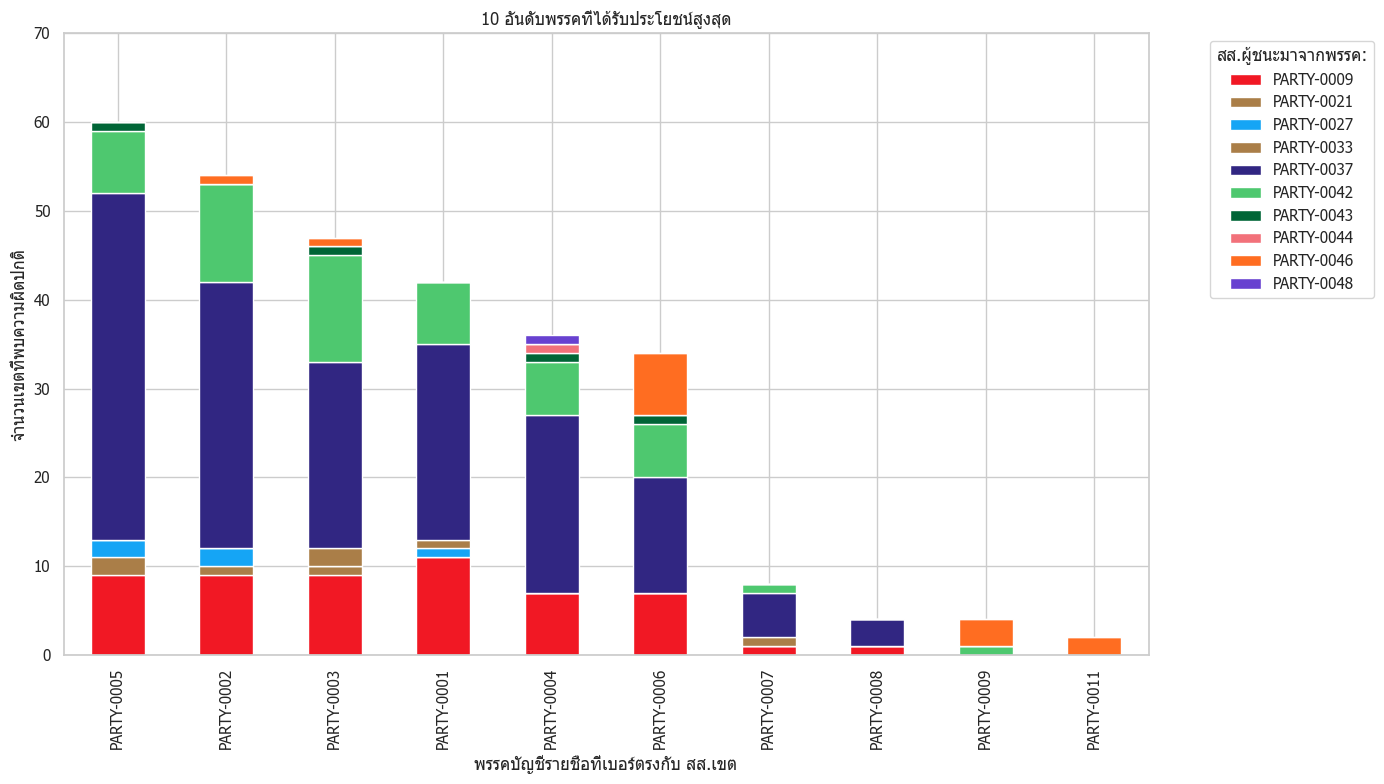

In [3]:
if suspicious_areas > 0:
    suspicious_df = df[df['is_suspicious']]
    
    # 10 อันดับพรรคบัญชีรายชื่อที่ได้ประโยชน์
    top_10_targets = suspicious_df['target_party_id'].value_counts().head(10).index
    plot_data = suspicious_df[suspicious_df['target_party_id'].isin(top_10_targets)]
    
    # สร้าง Pivot Table
    pivot_df = plot_data.groupby(['target_party_id', 'winner_party_id']).size().unstack(fill_value=0)
    
    # จัดเรียงตามจำนวนรวม
    pivot_df['total'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('total', ascending=False).drop(columns='total')

    # กำหนดสีตามที่ระบุ
    color_map = {
        'PARTY-0009': '#f11824',
        'PARTY-0021': '#aa7e48',
        'PARTY-0027': '#15a5f5',
        'PARTY-0033': '#aa7e48',
        'PARTY-0037': '#312682',
        'PARTY-0042': '#4ec86f',
        'PARTY-0043': '#006536',
        'PARTY-0044': '#f2717a',
        'PARTY-0046': '#ff6d21',
        'PARTY-0048': '#6841d0'
    }

    # สร้างรายการสีสำหรับพรรคที่มีใน Pivot Table (ถ้าไม่มีใน map จะใช้สีเทา)
    colors = [color_map.get(col, '#cccccc') for col in pivot_df.columns]

    # พล็อต
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=colors)
    plt.title('10 อันดับพรรคที่ได้รับประโยชน์สูงสุด')
    plt.xlabel('พรรคบัญชีรายชื่อที่เบอร์ตรงกับ สส.เขต')
    plt.ylabel('จำนวนเขตที่พบความผิดปกติ')
    plt.ylim(0, 70)
    plt.legend(title='สส.ผู้ชนะมาจากพรรค:', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("ไม่พบเขตที่มีความผิดปกติ")

### *ข้อมูลเพิ่มเติม
1. พรรคเบอร์6กับเบอร์9ถือว่าเป็นพรรคใหญ่ที่มีคนเลือกเยอะอยู่แล้ว ข้อมูลในกราฟข้างบนของพรรคเหล่านี้อาจจะบอกอะไรเรามากไม่ได้

2. พรรคเบอร์ 5, 2, 3 ได้คะแนนชนะเบอร์ 1 ซึ่งขัดกับทฤษฎีPrimary Effectที่บอกว่าคนไม่รู้จะกาเบอร์อะไรก็เลยกาเบอร์แรกสุดอย่างมีนัยสำคัญ

## สัดส่วนความผิดปกติแยกตามพรรคของผู้ชนะ
วิเคราะห์ว่าในจำนวนเขตที่แต่ละพรรคชนะ มีกี่เปอร์เซ็นต์ที่เข้าข่ายทฤษฎีการซื้อเสียง

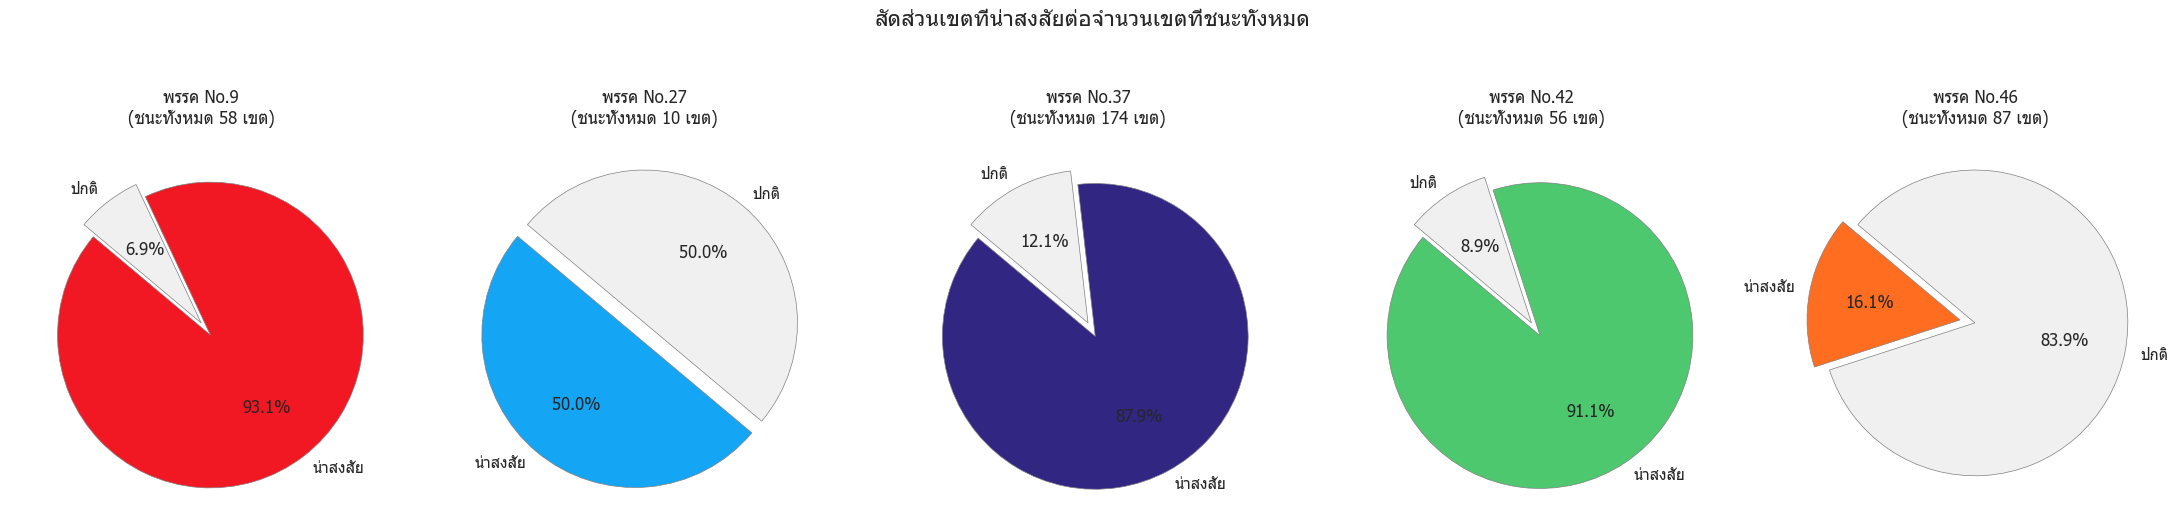

In [4]:
# รายชื่อพรรคที่ต้องการวิเคราะห์ (9, 27, 37, 42, 46)
target_winner_parties = ['PARTY-0009', 'PARTY-0027', 'PARTY-0037', 'PARTY-0042', 'PARTY-0046']

fig, axes = plt.subplots(1, 5, figsize=(22, 6))
fig.suptitle('สัดส่วนเขตที่น่าสงสัยต่อจำนวนเขตที่ชนะทั้งหมด', fontsize=16)

party_labels = {
    'PARTY-0009': 'พรรค No.9',
    'PARTY-0027': 'พรรค No.27',
    'PARTY-0037': 'พรรค No.37',
    'PARTY-0042': 'พรรค No.42',
    'PARTY-0046': 'พรรค No.46'
}

for i, party_id in enumerate(target_winner_parties):
    party_data = df[df['winner_party_id'] == party_id]
    total = len(party_data)
    suspicious = party_data['is_suspicious'].sum()
    normal = total - suspicious
    
    if total > 0:
        axes[i].pie([suspicious, normal], 
                    labels=['น่าสงสัย', 'ปกติ'], 
                    autopct='%1.1f%%', 
                    startangle=140, 
                    colors=[color_map.get(party_id, 'red'), '#f0f0f0'],
                    explode=(0.1, 0) if suspicious > 0 else (0, 0),
                    wedgeprops={'edgecolor': 'gray', 'linewidth': 0.5})
        axes[i].set_title(f"{party_labels[party_id]}\n(ชนะทั้งหมด {total} เขต)")
    else:
        axes[i].text(0.5, 0.5, 'ไม่มีข้อมูลการชนะ', ha='center', va='center')
        axes[i].set_title(f"{party_labels[party_id]}")
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## รายชื่อเขตที่พบความผิดปกติ แยกตามพรรค
แสดงรายชื่อเขตที่พรรค No.9, 27, 37, 42 และ 46 ชนะ และเข้าข่ายทฤษฎีการซื้อเสียง

In [5]:
# โหลดข้อมูลรหัสเขตและชื่อเขต
with open('../data/area_code/area_code.json', 'r', encoding='utf-8') as f:
    area_mapping_data = json.load(f)
area_name_map = {item['code']: item['name'] for item in area_mapping_data['areas']}

# รายชื่อพรรคที่ต้องการตรวจสอบ
target_ids = ['PARTY-0009', 'PARTY-0027', 'PARTY-0037', 'PARTY-0042', 'PARTY-0046']

print("เขตที่พบความผิดปกติ:\n")

for party_id in target_ids:
    label = party_labels.get(party_id, party_id)
    # กรองเฉพาะเขตที่พรรคนี้ชนะ และ is_suspicious เป็น True
    suspicious_list = df[(df['winner_party_id'] == party_id) & (df['is_suspicious'])]['area_code'].unique()
    
    if len(suspicious_list) > 0:
        print(f"{label} ({len(suspicious_list)} เขต):")
        # แสดงทั้งรหัสและชื่อเขต แบ่งกลุ่มบรรทัดละ 2 เขต
        formatted_list = [f"{area_name_map.get(code, 'ไม่พบชื่อเขต')}" for code in suspicious_list]
        # เรียงลำดับเพื่อให้ดูลำดับเขตง่ายขึ้น
        formatted_list = sorted(formatted_list, key=lambda x: x)

        for i in range(0, len(formatted_list), 2):
            print(f"  {'\n  '.join(formatted_list[i:i+2])}")
    else:
        print(f"{label}: ไม่พบเขตที่น่าสงสัย")
    print("-" * 30)

เขตที่พบความผิดปกติ:

พรรค No.9 (54 เขต):
  กาญจนบุรี เขต 1
  กาญจนบุรี เขต 5
  กาฬสินธุ์ เขต 1
  กาฬสินธุ์ เขต 2
  กาฬสินธุ์ เขต 4
  กาฬสินธุ์ เขต 6
  กำแพงเพชร เขต 3
  ขอนแก่น เขต 4
  ขอนแก่น เขต 7
  ขอนแก่น เขต 9
  ฉะเชิงเทรา เขต 1
  ชัยนาท เขต 1
  ชัยภูมิ เขต 1
  ชัยภูมิ เขต 2
  ชัยภูมิ เขต 5
  นครพนม เขต 2
  นครพนม เขต 4
  นครราชสีมา เขต 11
  นครราชสีมา เขต 12
  นครราชสีมา เขต 13
  นครราชสีมา เขต 15
  นครราชสีมา เขต 2
  นครราชสีมา เขต 4
  นครราชสีมา เขต 5
  นครราชสีมา เขต 6
  นครราชสีมา เขต 7
  นครราชสีมา เขต 8
  ปทุมธานี เขต 2
  มหาสารคาม เขต 5
  ร้อยเอ็ด เขต 5
  ร้อยเอ็ด เขต 6
  ร้อยเอ็ด เขต 8
  ลพบุรี เขต 4
  ศรีสะเกษ เขต 7
  สกลนคร เขต 3
  สกลนคร เขต 4
  สกลนคร เขต 7
  สุโขทัย เขต 1
  สุโขทัย เขต 2
  สุโขทัย เขต 3
  หนองบัวลำภู เขต 2
  อุดรธานี เขต 10
  อุดรธานี เขต 2
  อุดรธานี เขต 4
  อุดรธานี เขต 7
  อุดรธานี เขต 9
  อุตรดิตถ์ เขต 3
  อุบลราชธานี เขต 1
  อุบลราชธานี เขต 4
  อุบลราชธานี เขต 6
  เชียงราย เขต 2
  เลย เขต 1
  เลย เขต 2
  เลย เขต 4
------------------------------